Based on the model proposed in Zhao et al. (2009) 

It is designed to reflect:
   - tumor growth in the absence of chemotherapy,
   - patients’ negative wellness outcomes in response to chemotherapy,
   - the drug’s capability for killing tumor cells while also increasing toxicity,
   - n interaction between tumor cells and patient wellness
   
Dynamic model has two state variables:
 - m_t : Tumor size at time 't'
 - w_t : Patient's negative wellness at time 't'

Dynamic model has one action variable:
 - d_t : chemotherapy treatment given at time 't'
 
't' represents time (with month as unit) and t = 0, 1, ..., T−1

## Developing the environment

In [213]:
import numpy as np
import pandas as pd
from scipy.integrate import quad
import matplotlib.pyplot as plt

In [22]:
def model_dynamics(m0, mt, w0, wt, dt):
    
    # Model parameters
    a1 = 0.1
    a2 = 0.15
    b1 = 1.2
    b2 = 1.2

    d1 = 0.5
    d2 = 0.5

    m_0 = m0 # Tumor size at time '0', i.e., the begining of the study
    m_t = mt # Tumor size at time 't'
    ind_m_t = np.sign(m_t) # Indicator func. of tumor size at time 't': if tumour size = 0, patient is completely cured

    w_0 = w0 # Initial value of patient's (negative) wellness
    w_t = wt # Value of patient's (negative) wellness at time 't'
    
    d_t = np.clip(dt,a_min=0,a_max=1) # chemotherapy dose given at time 't': acceptable dose range of [0,1]

    # Indicator transition functions
    w_dot_t = a1 * max(m_t, m_0) + b1 * (d_t - d1)
    m_dot_t = (a2 * max(w_t,w_0) - b2 * (d_t - d2)) * ind_m_t
    
    return w_dot_t, m_dot_t

In [26]:
def next_state(w_t, w_dot_t, m_t, m_dot_t):
    
    w_t_new = w_t + w_dot_t
    m_t_new = m_t + m_dot_t
    
    return w_t_new, m_t_new

In [ ]:
def init_patient_state():
    
    """
    The initial values w0 and m0 for each patient are generated from independent uniform (0,2) deviates.
            
    """
    w0, m0 = np.random.uniform(low=0, high=2, size = 2)
    
    return w0, m0
    

In [200]:
def select_dosage(random=False, fixed_dosage=None):
    
    if fixed_dosage is not None:
        return fixed_dosage
    elif random:
        return np.random.choice([0.1, 0.4, 0.7, 1.0])    
    else:
        pass

In [120]:
def hazard_func(t):
    
    """
    The possible death of a patient in the course of a treatment is modeled by means of a hazard rate model.
    """
    
    mu_0 = -4
    mu_1, mu_2 = 1,2 # both the tumor size and the toxicity have an equally important influence on patient’s survival.
    
    lambda_t = np.exp(mu_0 + mu_1*wt_vec[t] + mu_2 * mt_vec[t])
    
    return lambda_t

In [128]:
def prob_death(start_t,end_t):
    
    """
    Computes the probability of the patient’s death during the time interval (start_t, end_t].
    """
    
    # intergral = quad(hazard_func, start_t, end_t, args = (wt,mt))
        
    # In discrete form, integration is just summation
    intergral = 0
    for t in [start_t,end_t]:
        intergral += hazard_func(t)
    
    p_death = 1 - np.exp(-intergral)
    
    return p_death

In [242]:
# Length of the treatment (in months)
treat_len = 6

# Compute the initial patient's state
w0, m0 = init_patient_state()

# Compute the dosage
d0 = select_dosage(random=True)

# Record the observed tumor size, wellness, and dosage
wt_vec = [] # Store toxicity
wt_vec.append(w0)

mt_vec = [] # Store tumor size
mt_vec.append(m0)

dt_vec = [] # Store applied dosage
dt_vec.append(d0)

p_death_vec = []
p_death_vec.append(None)

for _ in range(treat_len-1):
    
    # Compute the transition values
    w_dot_t, m_dot_t = model_dynamics(m0, mt_vec[-1], w0, wt_vec[-1], dt_vec[-1])

    # Compute the next state
    w_t_new, m_t_new = next_state(wt_vec[-1], w_dot_t, mt_vec[-1], m_dot_t)

    # Update the state vectors
    wt_vec.append(w_t_new)
    mt_vec.append(m_t_new)

    # Compute the probability of death
    end_t = int(len(wt_vec)-1)
    start_t = end_t - 1 

    p_death = prob_death(start_t, end_t)
    p_death_vec.append(p_death)
    
    if p_death >= 1.0:
        dt_vec.append(None)
        break
    else:
        dt_vec.append(select_dosage(fixed_dosage=.5))

In [243]:
pd.DataFrame({'tumor size' : mt_vec
            , 'negative wellness' : wt_vec
            , 'prob. death' : p_death_vec
            , 'dosage' : dt_vec})

,tumor size,negative wellness,prob. death,dosage
0,0.453565,0.223210,NaN,0.4
1,0.607046,0.148567,0.120384,0.5
2,0.640528,0.209271,0.141738,0.5
3,0.674009,0.273324,0.159678,0.5
4,0.715008,0.340725,0.181501,0.5
5,0.766117,0.412226,0.209928,0.5


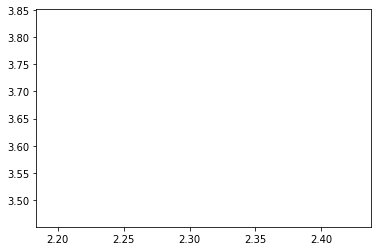

In [180]:
plt.plot(mt_vec[-1],max(wt_vec))

## ChemoSimulation class

In [302]:
import math
import gym
from gym import spaces, logger
from gym.utils import seeding
import numpy as np

class ChemoSimulation(gym.Env):
    
    def __init__(self):
        
        
        # Indicator transition functions parameters
        self.a1 = 0.1
        self.a2 = 0.15
        self.b1 = 1.2
        self.b2 = 1.2

        self.d1 = 0.5
        self.d2 = 0.5 
        
        self.m_0 = None # Tumor size at time '0', i.e., the begining of the study
        self.w_0 = None # Initial value of patient's (negative) wellness
        
        # Hazard function paremeters
        self.mu_0 = -4
        self.mu_1, self.mu_2 = 1,1 # both tumor size and toxicity have an equally important influence on patient’s survival.

        # Termination condition based on patient's probabilty of death
        self.death_prop_threshold = 1.0
        
        # Chemotherapy agent dose level is in the range [0,1]
        self.action_space = spaces.Box(low=0, high=1, shape = (1,), dtype=np.float32)
    
        # State space include the tumor size and patient's (negative) well-being
        self.observation_space = spaces.Box(low = np.array([0,0]), high = np.array([10,10]) , dtype=np.float32)
    
        self.seed()
        #self.viewer = None
        self.state = None  
    
    
    
    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]
    
    def step(self, action):
        
        err_msg = "%r (%s) invalid" % (action, type(action))
        assert self.action_space.contains(action), err_msg
        
        m_t, w_t = self.state
        
        # Chemotherapy dose given at time 't'
        # Acceptable dose range of [0,1]
        d_t = np.clip(action,a_min=0,a_max=1) 
        
        # Indicator func. of tumor size at time 't' 
        # If tumour size = 0, we consider patient to be completely cured (tumor won't grow again)
        ind_m_t = np.sign(m_t) 

        # Indicator transition functions
        w_dot_t = self.a1 * max(m_t, self.m_0) + self.b1 * (d_t - self.d1)
        m_dot_t = (self.a2 * max(w_t, self.w_0) - self.b2 * (d_t - self.d2)) * ind_m_t

        
        # Compute the next state values
        m_t_new = m_t + m_dot_t
        w_t_new = w_t + w_dot_t

        self.state = (m_t_new, w_t_new)
        
        # Hazard rate model
        lambda_t     = np.exp(self.mu_0 + self.mu_1*w_t + self.mu_2 * m_t)
        lambda_t_new = np.exp(self.mu_0 + self.mu_1*w_t_new + self.mu_2 * m_t_new)
        
        # Compute patient's probability of death (
        # Summing the Hazard rate model values for (t-1,t] time steps
        #  since in discrete time steps, integration is equal to the summation.
        p_death = 1 - np.exp(-(lambda_t+lambda_t_new))
        
        done = bool(p_death>=self.death_prop_threshold)
        
        if not done:
            reward = 1.0
        else:
            reward = 0.0
            logger.warn(
                    "You are calling 'step()' even though this "
                    "environment has already returned done = True. You "
                    "should always call 'reset()' once you receive 'done = "
                    "True' -- any further steps are undefined behavior."
                )
        
        return self.state, reward, done, p_death
    
    
    
    def reset(self, init_state=None):
        
        """
        The initial values w0 and m0 for each patient are generated from independent uniform (0,2) deviates.

        """

        # Accept an initial state at reset
        if init_state is not None:
            self.state = init_state 
        else:
            self.state = self.np_random.uniform(low=0, high=2, size = (2,))
        
        # Set the patient's tumor size and (negative) well-being at initialization 
        self.m_0, self.w_0 = self.state
        
        return np.array(self.state)

### Testing the environment

In [303]:
env = ChemoSimulation()

In [313]:
env.reset()

patient_status = []
reward = []


for _ in range(10):
    dose = env.action_space.sample()
    patient_status, reward, done, prob_death = env.step(np.array([1]))
    
    print(patient_status,prob_death,done,reward)
    if done:
        break
    

(array([0.02190003]), array([2.56572828])) [0.34287781] False 1.0
(array([-0.19324073]), array([3.19893039])) [0.45857106] False 1.0
(array([-0.07308029]), array([3.8321325])) [0.68521367] False 1.0
(array([-0.04790017]), array([4.46533461])) [0.90013585] False 1.0
(array([-0.11770036]), array([5.09853672])) [0.98477395] False 1.0
(array([-0.28248087]), array([5.73173883])) [0.99901871] False 1.0
(array([-0.54224169]), array([6.36494094])) [0.99997101] False 1.0
(array([-0.89698283]), array([6.99814305])) [0.99999942] False 1.0
(array([-1.34670429]), array([7.63134516])) [0.99999998] False 1.0
(array([-1.89140607]), array([8.26454727])) [1.] False 1.0
